In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
import torchvision
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import time
import numpy as np

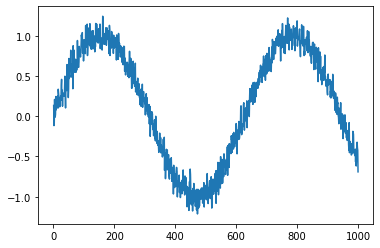

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.1, (T,))    # sin + 噪音
plt.plot(time, x)

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
print(features.shape, labels.shape)

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = utils.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

torch.Size([996, 4]) torch.Size([996, 1])


In [4]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss: {utils.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 10, 0.005)

epoch 1, loss: 0.017761
epoch 2, loss: 0.016133
epoch 3, loss: 0.015518
epoch 4, loss: 0.015452
epoch 5, loss: 0.015182
epoch 6, loss: 0.015342
epoch 7, loss: 0.014917
epoch 8, loss: 0.014603
epoch 9, loss: 0.015404
epoch 10, loss: 0.014948


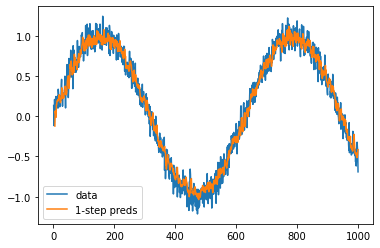

In [6]:
# 单步预测
onestep_preds = net(features)
plt.plot(time, x.detach().numpy())
plt.plot(time[tau:], onestep_preds.detach().numpy())
plt.legend(['data', '1-step preds'])

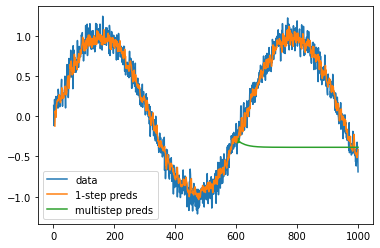

In [7]:
# 多步预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau: i].reshape((1, -1)))

plt.plot(time, x.detach().numpy())
plt.plot(time[tau:], onestep_preds.detach().numpy())
plt.plot(time[n_train + tau:], multistep_preds[n_train + tau:].detach().numpy())
plt.legend(['data', '1-step preds', 'multistep preds'])

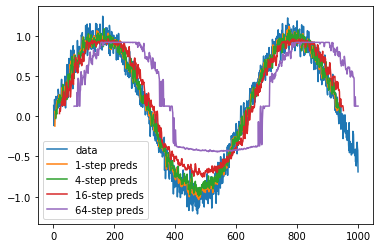

In [8]:
# k步预测
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau: i]).reshape(-1)

steps = (1, 4, 16, 64)
plt.plot(time, x.detach().numpy())
for k in steps:
    plt.plot(time[tau + k - 1: T - max_steps + k], features[:, (tau + k - 1)].detach().numpy())
plt.legend(['data', '1-step preds', '4-step preds', '16-step preds', '64-step preds'])